In [1]:
from typing import Literal, Optional, Union

from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [2]:
llm = ChatOllama(model="qwen2.5")

In [3]:
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(description="The next step in the routing process.")


router = llm.with_structured_output(Route)

In [4]:
class State(BaseModel):
    input: str
    decision: Optional[str] = None
    output: Optional[str] = None


class WriteAStory:
    """Callable class to generate a story using the LLM."""

    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        try:
            output = self.llm.invoke(state.input).content
        except Exception as e:
            output = f"Error generating story: {e}"
        return {"output": output}


class WriteAJoke:
    """Callable class to generate a joke using the LLM."""

    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        try:
            output = self.llm.invoke(state.input).content
        except Exception as e:
            output = f"Error generating joke: {e}"
        return {"output": output}


class WriteAPoem:
    """Callable class to generate a poem using the LLM."""

    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        try:
            output = self.llm.invoke(state.input).content
        except Exception as e:
            output = f"Error generating poem: {e}"
        return {"output": output}


class LlmCallRouter:
    """
    Routes user input to the appropriate LLM task (story, joke, or poem) using the provided router.

    The router determines the type of content to generate based on the user's request.
    """

    def __init__(self, router) -> None:
        self.router = router

    def __call__(self, state: State) -> dict:
        try:
            decision: Route = self.router.invoke(
                [
                    SystemMessage(
                        content="Route the input to story, joke or poem based on the user's request."
                    ),
                    HumanMessage(content=state.input),
                ]
            )
            return {"decision": decision.step}
        except Exception as e:
            return {"decision": None, "error": str(e)}


def route_decision(state: State) -> str:
    """
    Maps the decision in the state to the corresponding node name.

    Args:
        state (State): The current state containing the decision.

    Returns:
        str: The name of the node to route to.

    Raises:
        ValueError: If the decision is not recognized.
    """
    decision_node = {
        "story": "write_a_story",
        "poem": "write_a_poem",
        "joke": "write_a_joke",
    }
    node = decision_node.get(state.decision)
    if node is None:
        raise ValueError(f"Unknown decision: {state.decision}")
    return node

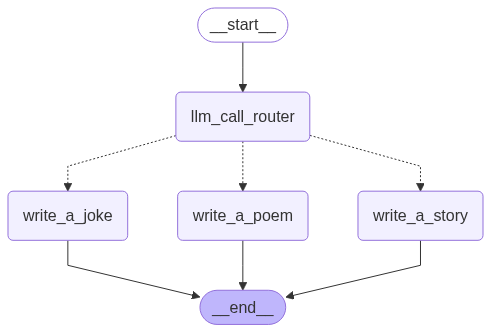

In [6]:
builder = StateGraph(State)
builder.add_node("llm_call_router", LlmCallRouter(router))
builder.add_node("write_a_story", WriteAStory(llm))
builder.add_node("write_a_joke", WriteAJoke(llm))
builder.add_node("write_a_poem", WriteAPoem(llm))

builder.add_edge(START, "llm_call_router")
builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "write_a_story": "write_a_story",
        "write_a_poem": "write_a_poem",
        "write_a_joke": "write_a_joke",
    },
)
builder.add_edge("write_a_story", END)
builder.add_edge("write_a_poem", END)
builder.add_edge("write_a_joke", END)

graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
result = graph.invoke(
    {"input": "Write to me a joke about Agentic AI"},
    config={"configurable": {"thread_id": "1"}},
)

In [8]:
result

{'input': 'Write to me a joke about Agentic AI',
 'decision': 'joke',
 'output': "Sure! Here's a light-hearted joke for you:\n\nWhy did the Agentic AI apply for a job at a travel agency?\n\nBecause it wanted to experience more than just its own virtual world!"}